# Inventory Demand Forecasting Project

This notebook demonstrates a step-by-step workflow for a demand forecasting project using a Random Forest Regressor. The focus is on data preprocessing, feature engineering, visualization, and model building to improve demand forecasting accuracy.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

## Loading and Exploring the Dataset
Let's load the data and perform basic exploratory analysis to understand its structure.

In [ ]:
df = pd.read_csv("../data/Store Demand Forecasting Train Data.csv")

df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


### Dataset Information
This step provides an overview of the data types and column counts.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


### Statistical Summary of Numerical Columns
Here, we generate summary statistics for numerical features.

In [ ]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


### Checking for Missing Values
We'll check for any missing values in the dataset to ensure data integrity.

In [ ]:
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

## Data Visualization
Visualizing the distribution and trends in the data helps in feature selection and understanding overall behavior.

### Visualizing the Demand Distribution
We use a histogram to see how demand is distributed.

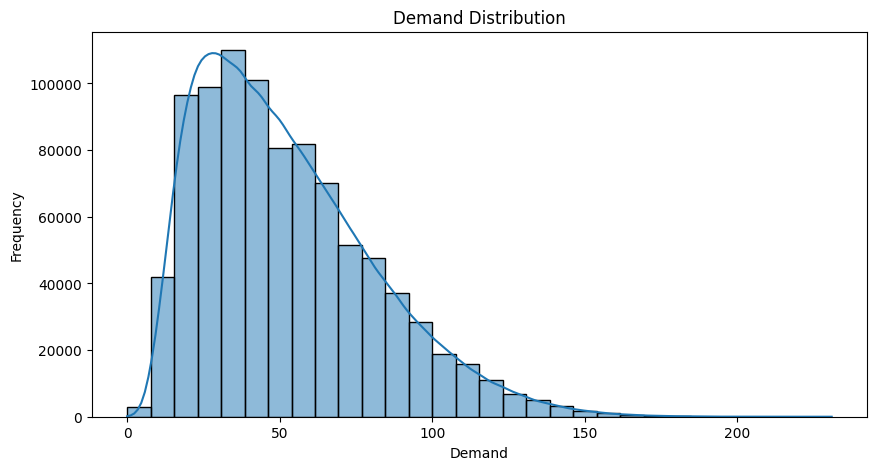

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df['sales'], bins=30, kde=True)
plt.title('Demand Distribution')
plt.xlabel('Demand')
plt.ylabel('Frequency')
plt.show()

### Converting 'date' to DateTime Format
This conversion allows us to extract date-based features for further analysis.

In [ ]:
df['date'] = pd.to_datetime(df['date'])

### Visualizing Demand Over Time
Plotting demand across time reveals seasonality or trend patterns.

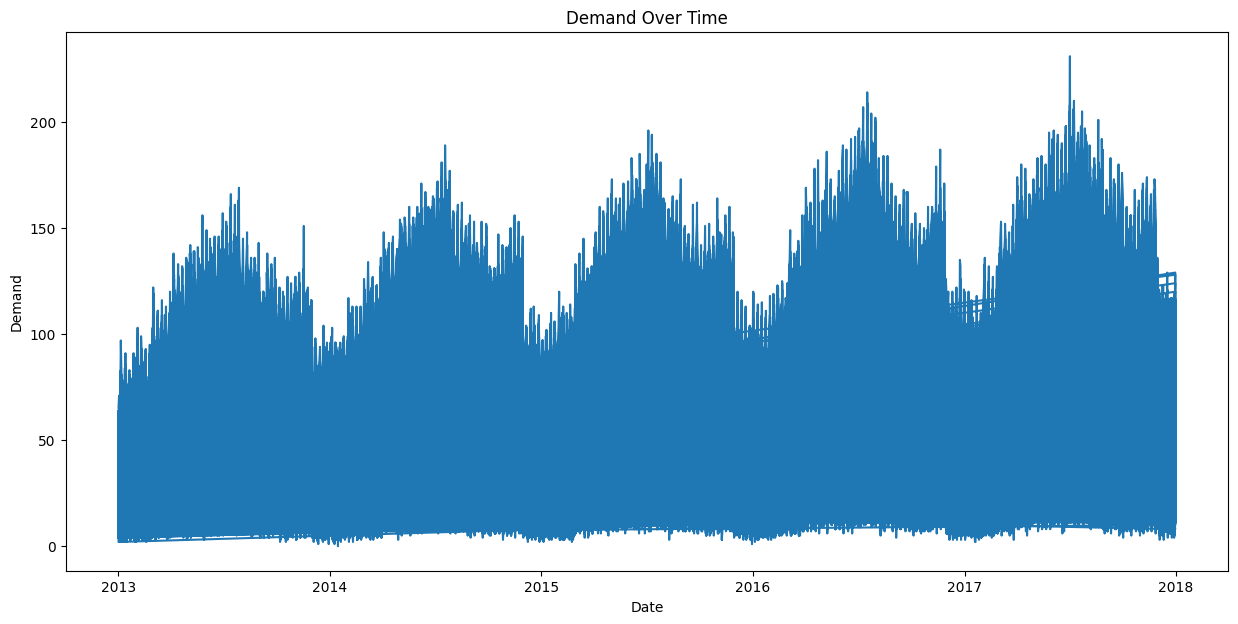

In [ ]:

plt.figure(figsize=(15, 7))
plt.plot(df['date'], df['sales'])
plt.title('Demand Over Time')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.show()

## Feature Engineering
Feature engineering aims to create new features that capture useful information for the model.

### Extracting Month from Date
The month can reveal seasonal trends that impact demand.

In [ ]:
df['month'] = df['date'].dt.month

### Visualizing Total Demand by Month
We group the data by month and visualize total sales to identify seasonal patterns.

<Axes: title={'center': 'Monthly Demand'}, xlabel='month'>

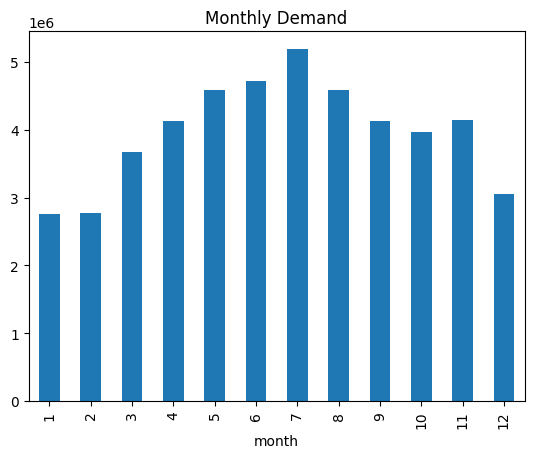

In [ ]:
monthly_demand = df.groupby('month')['sales'].sum()
monthly_demand.plot(kind='bar', title='Monthly Demand')

### Extracting Day of the Week from Date
This feature helps understand weekly cycles in demand.

In [ ]:
df['day_of_week'] = df['date'].dt.dayofweek 

### Visualizing Average Demand by Day of the Week
We visualize average sales per day of the week to spot trends.

<Axes: title={'center': 'Average Demand by Day of Week'}, xlabel='day_of_week'>

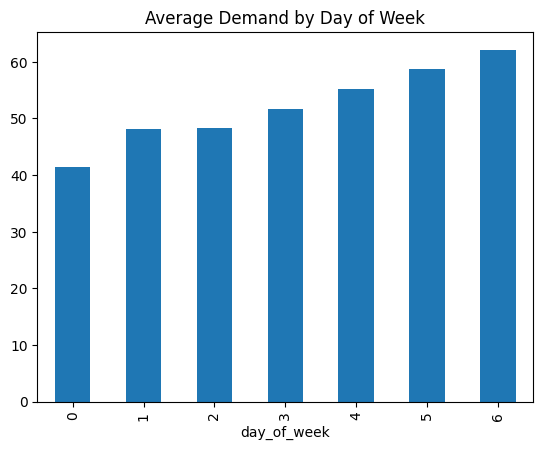

In [ ]:
weekly_demand = df.groupby('day_of_week')['sales'].mean()
weekly_demand.plot(kind='bar', title='Average Demand by Day of Week')

### Extracting Year from Date
This feature may capture long-term demand trends and changes.

In [ ]:
df['year'] = df['date'].dt.year

### Grouping and Visualizing Yearly Demand Trends
The total demand for each year is plotted to identify trends.

<Axes: title={'center': 'Yearly Demand'}, xlabel='year'>

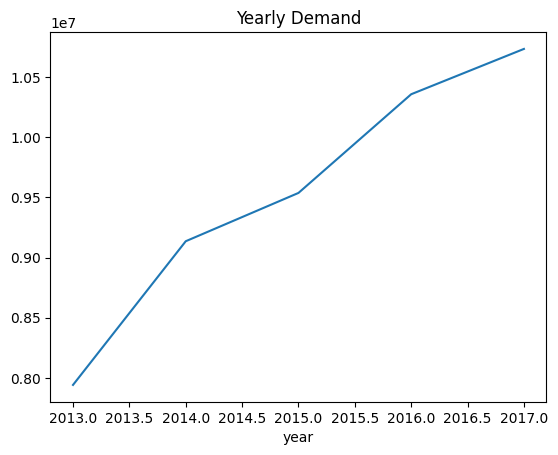

In [ ]:
yearly_demand = df.groupby('year')['sales'].sum()
yearly_demand.plot(kind='line', title='Yearly Demand')

### Creating Additional Features
This features will help us make more precise predictions

In [ ]:
df['day'] = df['date'].dt.day
df['week_of_year'] = df['date'].dt.isocalendar().week

,date,store,item,sales,month,day_of_week,year,day,week_of_year
0,2013-01-01,1,1,13,1,1,2013,1,1
1,2013-01-02,1,1,11,1,2,2013,2,1
2,2013-01-03,1,1,14,1,3,2013,3,1
3,2013-01-04,1,1,13,1,4,2013,4,1
4,2013-01-05,1,1,10,1,5,2013,5,1


### Creating Additional Time-Based Features
- **'demand_lag_1'**: The previous day's sales.
- **'demand_lag_7'**: The sales from one week ago.
These features help capture temporal dependencies in sales.

In [ ]:
df['demand_lag_1'] = df['sales'].shift(1)

df['demand_lag_7'] = df['sales'].shift(7)

df.head()

,date,store,item,sales,month,day_of_week,year,day,week_of_year,demand_lag_1,demand_lag_7
0,2013-01-01,1,1,13,1,1,2013,1,1,NaN,NaN
1,2013-01-02,1,1,11,1,2,2013,2,1,13.0,NaN
2,2013-01-03,1,1,14,1,3,2013,3,1,11.0,NaN
3,2013-01-04,1,1,13,1,4,2013,4,1,14.0,NaN
4,2013-01-05,1,1,10,1,5,2013,5,1,13.0,NaN


### Checking for NaNs

In [14]:
df.isna().sum()

date            0
store           0
item            0
sales           0
month           0
day_of_week     0
year            0
day             0
week_of_year    0
demand_lag_1    1
demand_lag_7    7
dtype: int64

### Dealing with NaNs
The total mean of sales is filled for the NaNs in **'demand_lag_1'** and **'demand_lag_7'** features.

In [15]:
mean_demand = df['sales'].mean()
df['demand_lag_1'].fillna(mean_demand, inplace=True)
df['demand_lag_7'].fillna(mean_demand, inplace=True)

/var/folders/xg/xfdptgfd30j5qj2w13xgqcq00000gn/T/ipykernel_22790/234933885.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['demand_lag_1'].fillna(mean_demand, inplace=True)
/var/folders/xg/xfdptgfd30j5qj2w13xgqcq00000gn/T/ipykernel_22790/234933885.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

### Checking for NaNs

In [16]:
df.isna().sum()

date            0
store           0
item            0
sales           0
month           0
day_of_week     0
year            0
day             0
week_of_year    0
demand_lag_1    0
demand_lag_7    0
dtype: int64

### Creating Additional Features 
We compute rolling means for the 'sales' column over 7 and 30-day windows to capture short-term and long-term trends in demand.

In [ ]:
df['rolling_mean_7'] = df['sales'].rolling(window=7).mean()
df['rolling_mean_30'] = df['sales'].rolling(window=30).mean()

### Checking for missing values

In [18]:
df.isna().sum()

date                0
store               0
item                0
sales               0
month               0
day_of_week         0
year                0
day                 0
week_of_year        0
demand_lag_1        0
demand_lag_7        0
rolling_mean_7      6
rolling_mean_30    29
dtype: int64

### Dealing with Missing Values
Missing values are filled with rolling means of sales for each period.

In [19]:
df['rolling_mean_7'] = df['sales'].rolling(window=7).mean()
df['rolling_mean_7'].fillna(df['sales'].mean(), inplace=True)

df['rolling_mean_30'] = df['sales'].rolling(window=7).mean()
df['rolling_mean_30'].fillna(df['sales'].mean(), inplace=True)

df.isna().sum()

/var/folders/xg/xfdptgfd30j5qj2w13xgqcq00000gn/T/ipykernel_22790/298807376.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['rolling_mean_7'].fillna(df['sales'].mean(), inplace=True)
/var/folders/xg/xfdptgfd30j5qj2w13xgqcq00000gn/T/ipykernel_22790/298807376.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

date               0
store              0
item               0
sales              0
month              0
day_of_week        0
year               0
day                0
week_of_year       0
demand_lag_1       0
demand_lag_7       0
rolling_mean_7     0
rolling_mean_30    0
dtype: int64

### Creating Additional Feature
We calculate the percentage change in sales compared to the previous day, which helps capture relative changes in demand.

In [20]:
df['demand_pct_change'] = df['sales'].pct_change()
df.isna().sum()

date                 0
store                0
item                 0
sales                0
month                0
day_of_week          0
year                 0
day                  0
week_of_year         0
demand_lag_1         0
demand_lag_7         0
rolling_mean_7       0
rolling_mean_30      0
demand_pct_change    1
dtype: int64

We fill the missing values with the mean of demand_pct_change

In [21]:
df['demand_pct_change'] = df['demand_pct_change'].fillna(df['demand_pct_change'].mean())
df.isna().sum()

date                 0
store                0
item                 0
sales                0
month                0
day_of_week          0
year                 0
day                  0
week_of_year         0
demand_lag_1         0
demand_lag_7         0
rolling_mean_7       0
rolling_mean_30      0
demand_pct_change    0
dtype: int64

Whole list of new features

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   date               913000 non-null  datetime64[ns]
 1   store              913000 non-null  int64         
 2   item               913000 non-null  int64         
 3   sales              913000 non-null  int64         
 4   month              913000 non-null  int32         
 5   day_of_week        913000 non-null  int32         
 6   year               913000 non-null  int32         
 7   day                913000 non-null  int32         
 8   week_of_year       913000 non-null  UInt32        
 9   demand_lag_1       913000 non-null  float64       
 10  demand_lag_7       913000 non-null  float64       
 11  rolling_mean_7     913000 non-null  float64       
 12  rolling_mean_30    913000 non-null  float64       
 13  demand_pct_change  913000 non-null  float64 

Dealing with infinite values and dropping all the remaining missing values

In [23]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna()

,date,store,item,sales,month,day_of_week,year,day,week_of_year,demand_lag_1,demand_lag_7,rolling_mean_7,rolling_mean_30,demand_pct_change
1,2013-01-02,1,1,11,1,2,2013,2,1,13.0,52.250287,52.250287,52.250287,-0.153846
2,2013-01-03,1,1,14,1,3,2013,3,1,11.0,52.250287,52.250287,52.250287,0.272727
3,2013-01-04,1,1,13,1,4,2013,4,1,14.0,52.250287,52.250287,52.250287,-0.071429
4,2013-01-05,1,1,10,1,5,2013,5,1,13.0,52.250287,52.250287,52.250287,-0.230769
5,2013-01-06,1,1,12,1,6,2013,6,1,10.0,52.250287,52.250287,52.250287,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,12,2,2017,27,52,41.0,51.000000,62.714286,62.714286,0.536585
912996,2017-12-28,10,50,59,12,3,2017,28,52,63.0,63.000000,62.142857,62.142857,-0.063492
912997,2017-12-29,10,50,74,12,4,2017,29,52,59.0,75.000000,62.000000,62.000000,0.254237
912998,2017-12-30,10,50,62,12,5,2017,30,52,74.0,70.000000,60.857143,60.857143,-0.162162


We create the correlation matrix to check for the correlating features that can help improve the model

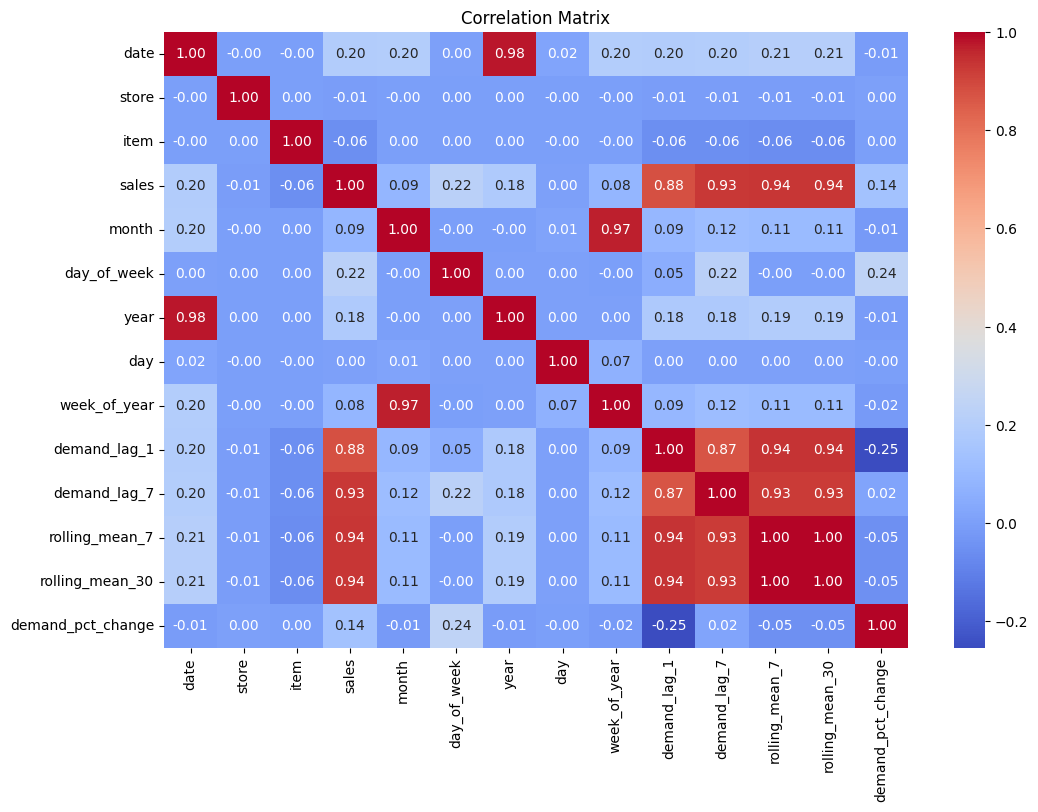

In [24]:
corr = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

Separating training and test datasets by timestamps to avoid data leakage

In [ ]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.set_index('date', inplace=True)
train_data = df[df.index < pd.Timestamp('2017-01-01')]
test_data = df[df.index >= pd.Timestamp('2017-01-01')]

X_train = train_data.drop(columns='sales')
y_train = train_data['sales']
X_test = test_data.drop(columns='sales')
y_test = test_data['sales']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

date                 0
store                0
item                 0
sales                0
month                0
day_of_week          0
year                 0
day                  0
week_of_year         0
demand_lag_1         0
demand_lag_7         0
rolling_mean_7       0
rolling_mean_30      0
demand_pct_change    2
dtype: int64


Training the model and showing its MAE

In [31]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled, y_train)

y_pred = rf_model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 0.07221967123287683


HyperParameter tuning with GridSearchCV

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters from Grid Search: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Mean Absolute Error of Random Forest Model: 0.07221378996346126


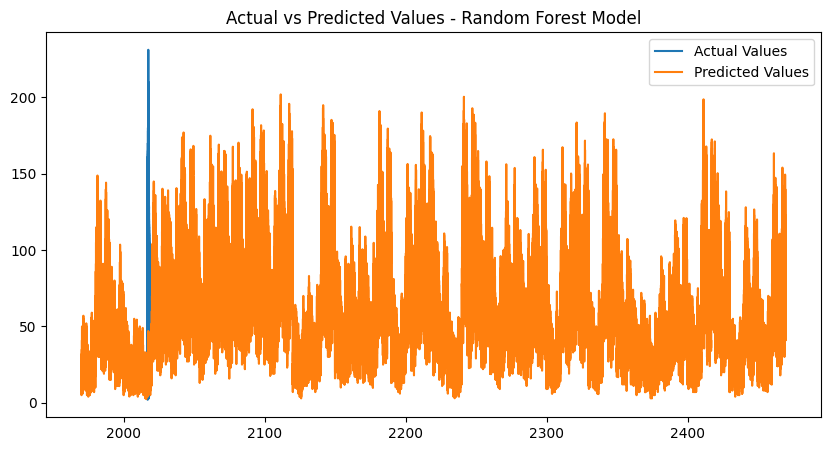

In [ ]:
param_grid = {
    'n_estimators': [50, 100],     
    'max_depth': [5, 10, None],      
    'min_samples_split': [2, 5],    
    'min_samples_leaf': [1, 2]        
}

tscv = TimeSeriesSplit(n_splits=3)  

grid_search = GridSearchCV(estimator=rf_model,
                           param_grid=param_grid,
                           scoring='neg_mean_absolute_error',
                           cv=tscv,
                           verbose=1,
                           n_jobs=8)

grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_
print("Best Parameters from Grid Search:", grid_search.best_params_)

predictions = best_rf_model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error of Random Forest Model:", mae)

Feature Importance
Understanding which features have the most influence on the model's predictions helps with interpretability and feature selection.

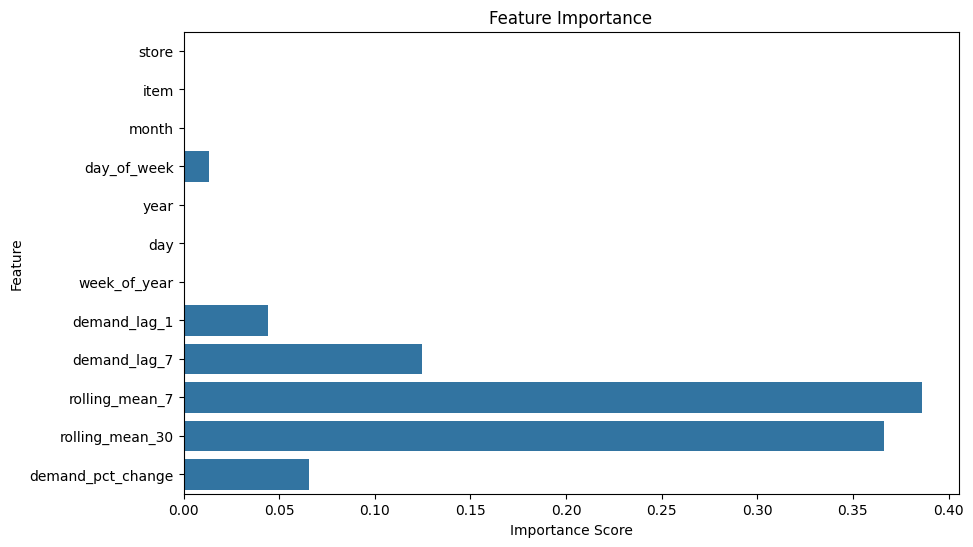

In [ ]:
feature_importances = best_rf_model.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_names)
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

We use common evaluation metrics such as RMSE and R² score.

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test Set RMSE:", rmse)

r2 = r2_score(y_test, y_pred)
print("Test Set R² Score:", r2)

Test Set RMSE: 0.41650980155876344
Test Set R² Score: 0.9998257471676217


Showing Model performance on graph by comparing actual sales and predicted by the model sales

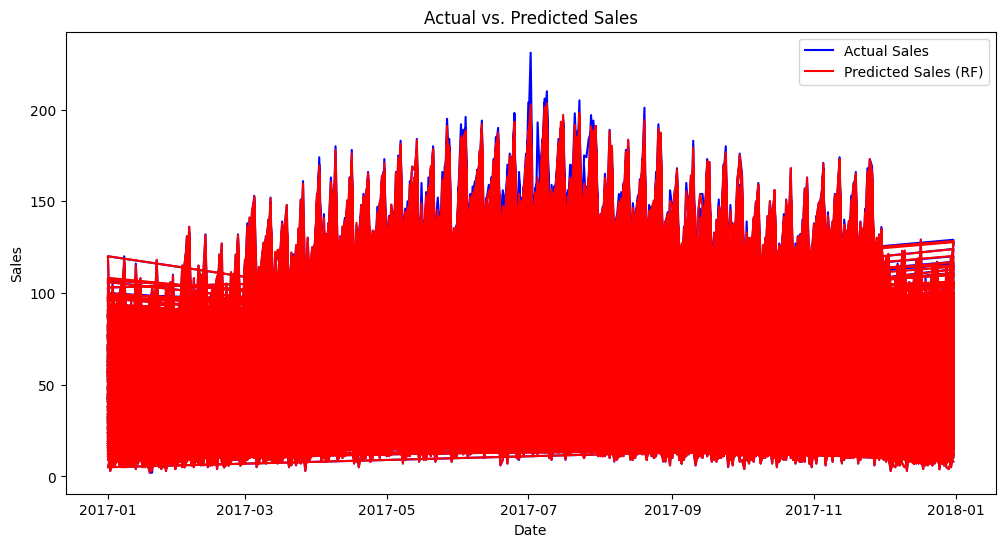

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, y_test, label='Actual Sales', color='b')
plt.plot(test_data.index, y_pred, label='Predicted Sales (RF)', color='r')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs. Predicted Sales')
plt.legend()
plt.show()